## 실습 목표

- 추천 시스템의 개념과 목적을 이해한다.
- Implicit 라이브러리를 활용하여 Matrix Factorization(이하 MF) 기반의 추천 모델을 만들어 본다.
- 음악 감상 기록을 활용하여 비슷한 아티스트를 찾고 아티스트를 추천해 본다.
- 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 익힌다
- 유저의 행위 데이터 중 Explicit data와 Implicit data의 차이점을 익힌다.
- 새로운 데이터셋으로 직접 추천 모델을 만들어 본다.

## 추천 시스템이란 게 뭔가요?

### Q1. 협업 필터링(Collaborative Filtering) 방식과 콘텐츠 기반 필터링(Contents-based Filtering) 방식의 차이점이 무엇인가요?

협업 필터링은 다수의 `사용자의 아이템 구매 이력 정보`만으로 사용자간 유사성 및 아이템 간 유사성을 파악하지만,

콘텐츠 기반 필터링은 `아이템의 고유의 정보`를 바탕으로 아이템 간 유사성을 파악합니다.

다시 말해, 협업 필터링에서는 **아이템과 사용자 간의 행동 또는 관계에만 주목**할 뿐 아이템 자체의 고유한 속성에 주목하지 않습니다.

콘텐츠 기반 필터링에서는 **아이템 자체의 속성에만 주목**하고 사용자와 아이템 간의 관련성 에는 주목하지 않습니다

### Q2. 다수의 사용자의 판단을 기반으로 정확한 추천을 가능하게 하는 추천시스템의 핵심 근간은 협업 필터링입니다만, 협업 필터링을 바로 사용할 수 없게 만드는 세가지 제약 조건은 무엇일까요?

1. 시스템이 충분한 정보를 모으지 못한 사용자나 아이템에 대한 추론을 할 수 없는 상태인 콜드 스타트(Cold Start) 상황

2. 계산량이 너무 많아 추천의 효율이 떨어지는 상황

3. 롱테일의 꼬리 부분, 즉 사용자의 관심이 저조한 항목의 정보가 부족하여 추천에서 배제되는 상황

## 데이터 탐색하기와 전처리

### 데이터 준비

- `tsv`는 Tab-Separated Values의 약자로서, Comma-Separated Values의 약자인 `csv` 파일과 거의 동일하나 구분자만 comma가 아니라 `tab('\t')` 문자를 활용

In [1]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head(10)

,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,6531c8b1-76ea-4141-b270-eb1ac5b41375,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,21f3573f-10cf-44b3-aeaa-26cccd8448b5,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,c5db90c4-580d-4f33-b364-fbaa5a3a58b5,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,0639533a-0402-40ba-b6e0-18b067198b73,lunachicks,403


In [2]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [3]:
# 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data['artist'] = data['artist'].str.lower()
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [4]:
data['artist'].str

> 첫번째 유저가 어떤 노래를 듣는지 확인

In [5]:
condition = (data['user_id']== data.loc[0, 'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


-------
-------
-------
-------

In [6]:
data.loc[0, 'user_id']

'00000c289a1829a808ac09c00daf10bc3c4e223b'

In [7]:
data['user_id'] == data.loc[0, 'user_id']

0            True
1            True
2            True
3            True
4            True
            ...  
17535650    False
17535651    False
17535652    False
17535653    False
17535654    False
Name: user_id, Length: 17535655, dtype: bool

-------
-------
-------
-------

### 데이터 탐색

추천 모델을 만들기 전에 데이터의 기본적인 정보를 보고 갑시다. 아래 항목들을 확인해 보고 싶습니다.

- 유저 수, 아티스트 수, 인기 많은 아티스트
- 유저들이 몇 명의 아티스트를 듣고 있는지에 대한 통계
- 유저 play 횟수 중앙값에 대한 통계

In [8]:
# 유저 수
data['user_id'].nunique()

358868

In [9]:
# 아티스트 수
data['artist'].nunique()

291346

In [10]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(30)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
system of a down         37267
queen                    34174
u2                       33206
daft punk                33001
the cure                 32624
led zeppelin             32295
placebo                  32072
depeche mode             31916
david bowie              31862
bob dylan                31799
death cab for cutie      31482
arctic monkeys           30348
foo fighters             30144
air                      29795
the rolling stones       29754
nine inch nails          28946
sigur rós                28901
green day                28732
massive attack           28691
moby                     28232
Name: user_id, dtype: int64

----
----
----
----

In [11]:
data.groupby('artist')['user_id']

In [12]:
data.groupby('artist')['user_id'].count()

artist
 04)]                                         1
 2                                            4
 58725ab=>                                    1
 80li̇ yillarin türkçe sözlü aşk şarkilari    1
 amy winehouse                                1
                                             ..
￼antonio mairena                              1
￼beastie boys                                 1
��|                                           1
��疲暎�                                         1
�������                                       1
Name: user_id, Length: 291346, dtype: int64

In [13]:
data.groupby('artist').size().sort_values(ascending=False).head(5)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
dtype: int64

----
----
----
----

In [14]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [15]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358868.000000
mean        142.187676
std         213.089902
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

In [16]:
data.groupby('user_id')['play'].sum().describe()

count    358868.000000
mean      10515.156066
std       14761.252419
min           1.000000
25%        2402.000000
50%        6140.000000
75%       13131.000000
max      787884.000000
Name: play, dtype: float64

### 모델 검증을 위한 사용자 초기 정보 세팅

In [17]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


------
------
------
------

In [18]:
data.isin(['zimin']).tail(6)

,user_id,artist,play
17535654,False,False,False
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [19]:
t = data.isin(['zimin'])
t['user_id'].any()

True

In [20]:
t['artist'].any()

False

In [21]:
t['artist'].all()

False

------
------
------
------

### 모델에 활용하기 위한 전처리 (실습)

우리가 다루는 데이터에서는 user와 artist 각각에 번호를 붙이고 싶습니다. 보통 이런 작업을 indexing이라고 합니다. 추천 시스템, 자연어 처리에서 자주 하는 작업들이라 직접 해보시면 좋겠습니다.

In [22]:
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

In [23]:
user_unique[:5]

array(['00000c289a1829a808ac09c00daf10bc3c4e223b',
       '00001411dc427966b17297bf4d69e7e193135d89',
       '00004d2ac9316e22dc007ab2243d6fcb239e707d',
       '000063d3fe1cf2ba248b9e3c3f0334845a27a6bf',
       '00007a47085b9aab8af55f52ec8846ac479ac4fe'], dtype=object)

In [24]:
data['user_id'].nunique()

358869

In [25]:
user_to_idx = {v: k for k, v in enumerate(user_unique)}
artist_to_idx = {v: k for k, v in enumerate(artist_unique)}

```python
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}
```

In [26]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['black eyed peas'])

358868
376


In [27]:
user_unique[-3:]

array(['ffff9ef87a7d9494ada2f9ade4b9ff637c0759ac', 'sep 20, 2008',
       'zimin'], dtype=object)

In [28]:
user_to_idx.get('zimin')

358868

In [29]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,376,30
1,358868,270115,30
2,358868,3746,30
3,358868,62,30


## 사용자의 명시적/암묵적 평가

어떤 유저가 어떤 곡을 1회만 들었다고 하면 그것은 좋은 것일까 나쁜 것일까? 이런 implicit한 데이터는 해석하는 것에 도메인 지식이 많이 필요하다.

In [30]:
# 1회만 play한 데이터의 비율을 보는 코드
only_one = data[data['play']<2]
one, all_data = len(only_one), len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')  # f-format에 대한 설명은 https://bit.ly/2DTLqYU

147740,17535660
Ratio of only_one over all data is 0.84%


In [31]:
only_one.head()

,user_id,artist,play
1854,38,1431,1
1855,38,1432,1
1856,38,1433,1
1857,38,1434,1
1858,38,1435,1


우리가 앞으로 만들어갈 모델에서는 암묵적 데이터의 해석을 위해 다음과 같은 규칙을 적용할 것입니다.

- 한 번이라도 들었으면 선호한다고 판단한다.
- 많이 재생한 아티스트에 대해 가중치를 주어서 더 확실히 좋아한다고 판단한다.


## Matrix Factorization(MF)

아래 그림의 왼쪽에서 보는 것처럼, 우리는 m명의 사용자들이 n명의 아티스트에 대해 평가한 데이터를 포함한 (m,n) 사이즈의 평가 행렬(Rating Matrix)을 만들 것입니다. 행렬 중 일부는 데이터가 채워져 있지만, 나머지 부분은 데이터가 비어 있습니다. 우리가 앞에서 살펴보았던 추천 시스템의 협업 필터링(Collaborative Filtering)이란 결국은 이런 평가 행렬을 전제로 하는 것입니다. 만약 우리가 이 평가 행렬의 비어 있는 부분을 포함한 완벽한 정보를 얻을 수만 있다면 (모든 사용자의 모든 아이템에 대한 선호도를 다 파악한 셈이니) 그야말로 완벽한 추천이 가능해질 것입니다.

우리는 추천 시스템의 다양한 모델 중 Matrix Factorization(MF, 행렬 분해) 모델을 사용하겠습니다. MF 모델은 2006년 Netflix에서 백만 달러의 상금을 걸고 개최한 자사 추천 시스템의 성능을 10% 이상 향상시키는 챌린지를 계기로 알려지게 되었습니다. 기본 아이디어는 아래 그림과 같습니다. (m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현 가능할 수 있다는 간단한 아이디어입니다. 대체로 k는 m이나 n보다 훨씬 작은 값이기 때문에 계산량 측면으로도 훨씬 유리해집니다. 하지만 아이디어의 단순함에도 불구하고 MF 모델은 성능이 준수하고 Scalability가 좋아서 많이 사용되는 모델입니다.

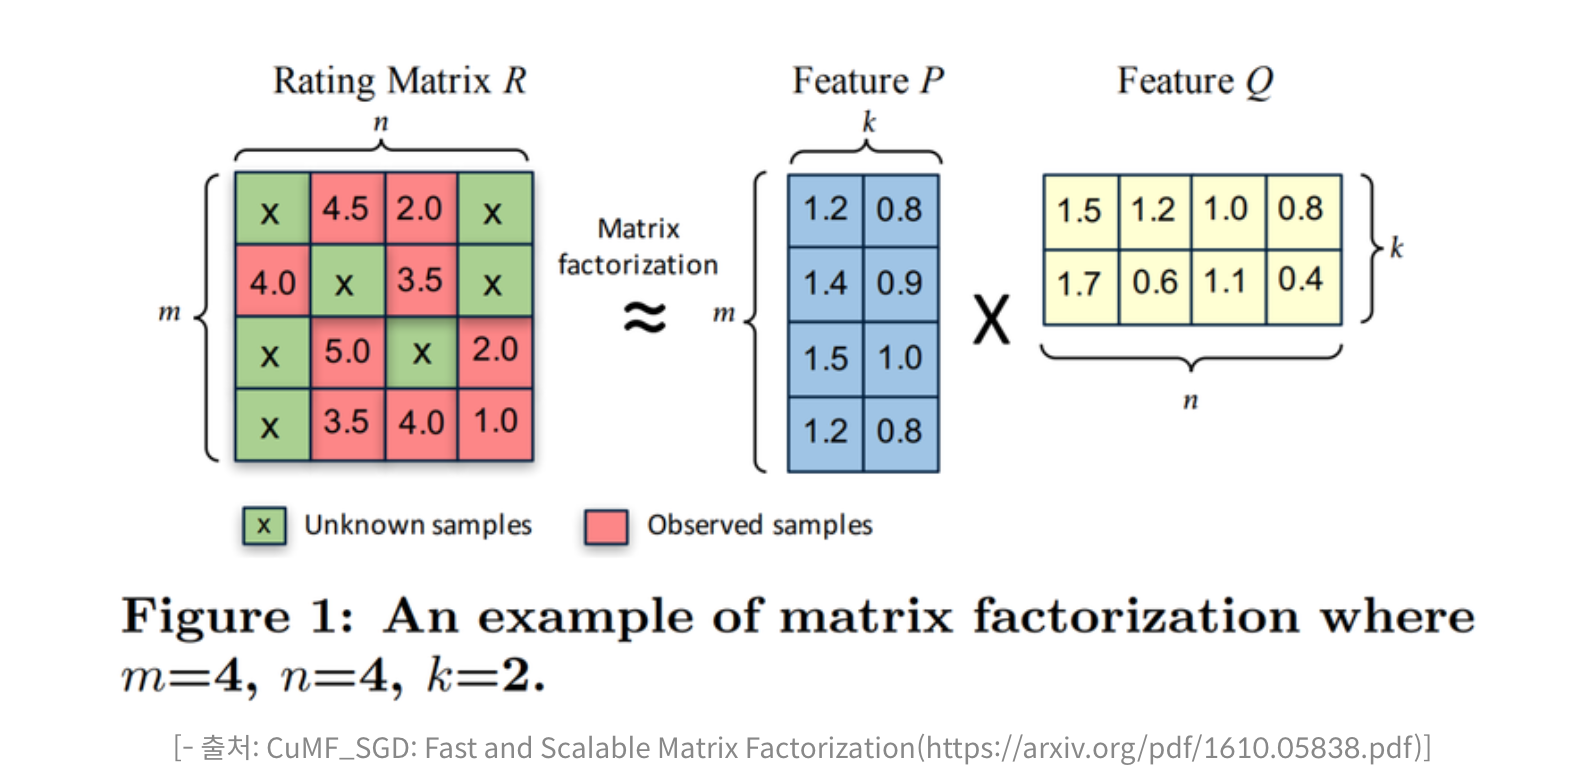

아래 그림을 다시 한번 봅시다. 위에 소개한 MF 모델의 개요도와 크게 다를 것은 없습니다. 단지, MF 모델을 사용자에게 영화를 추천하는 모델에 대입해서 그려 보았다는 정도의 차이가 있습니다. 위 그림 방식으로 말하자면 m=4, n=5, k=2인 MF 모델이 되겠군요.

위에서 MF 모델은 큰 평가 행렬 R을 두 개의 Feature Matrix P와 Q로 분해한다고 하였습니다.
무엇의 Feature일까요? (m, k) 사이즈의 Feature Matrix P는 k 차원의 벡터를 사용자 수만큼 모아놓은 행렬입니다. 그렇다면 아래 그림에서 첫 번째 벡터 $P_0=(1, 0.1)$은 바로 빨간 모자를 쓴 첫 번째 사용자의 특성(Feature) 벡터가 됩니다.
같은 방식으로 Q 행렬의 첫 번째 벡터 $Q_0=(0.9, -0.2)$는 해리포터 영화의 특성 벡터가 되겠지요. MF 모델은 이 두 벡터를 내적해서 얻어지는 $0.88$이 바로 $R_{0,0}$ 으로 정의되는 사용자의 영화 선호도로 보는 모델입니다.

모델의 목표는 모든 유저와 아이템에 대해 k-dimension의 벡터를 잘 만드는 것입니다.
벡터를 잘 만드는 기준은 유저 i의 벡터($U_i$)와 아이템 j의 벡터($I_j$)를 내적했을 때 유저 i가 아이템 j에 대해 평가한 수치($M_{ij}$)와 비슷한지 입니다.

$U_i \cdot I_j = M_{ij}$


MF에도 다양한 변형이 있습니다. 이번에 사용할 모델은 Collaborative Filtering for Implicit Feedback Datasets 논문에서 제안한 모델을 사용할 것입니다.

이 모델의 경우 이전 스텝에서 제가 'black eyed peas'를 play했다는 데이터를 추가했기 때문에 저의 벡터와 black eyed peas의 벡터를 곱했을 때 1에 가까워야 모델이 잘 학습하는 것을 목표로 합니다.

오해할 수 있는데, 제가 black eyed peas를 5번 들었어도 모델이 근사하고자 하는 것이 아티스트를 선호하는지 안 하는지를 맞추는 것이기 때문에 두 벡터를 곱했을 때 5에 가까워지는 대신 1에 가까워져야 합니다.

이를 통해서 제가 들어보지 못한 queen에 대해서도 저의 벡터와 queen의 벡터를 곱하여 수치를 예상할 수 있습니다.

만약 목표가 유저의 재생 횟수를 맞춰야 하는 것(혹은 별점을 맞추는 것)이라면 그에 맞는 다른 모델을 사용해야 합니다.

구조가 거의 똑같고 모델의 목표가 재생횟수를 맞춰지는 쪽으로 학습(유저와 아이템의 벡터를 만들기)하면 됩니다! 궁금하다면 참고 자료를 확인해 주세요.

## CSR(Compressed Sparse Row) Matrix

유저 X 아이템 평가 행렬을 다시 생각해 봅시다. 유저는 36만 명이고 아티스트는 29만 명입니다. 이를 행렬로 표현하고 행렬의 각 원소에 정수 한 개 (1byte)가 들어간다면 36만 * 29만 * 1byte $\approx$ 97GB가 필요합니다.

### Q7. 평가행렬 용량이 이렇게 커진 이유는 무엇일까요? 혹시 메모리 공간을 낭비하게 되는 요소는 없을까요?

유저 수 X 아티스트 수만큼의 정보 안에는 유저가 들어보지 않은 아티스트에 대한 정보까지 모두 행렬에 포함되어 계산되기 때문입니다. 아무리 많은 아티스트를 들어 본 유저도 수백 명을 넘어갈 만큼의 아티스트를 들어보지 못했는데, 총 아티스트는 29만 명이 넘기 때문에 평가행렬 내의 대부분의 공간은 0으로 채워집니다. 이런 행렬을 Sparse Matrix라고 합니다. 이런 메모리 낭비를 최소화하기 위해서는 유저가 들어본 아티스트에 대해서만 정보만을 저장하면서 전체 행렬 형태를 유추할 수 있는 데이터 구조가 필요합니다.

CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다.


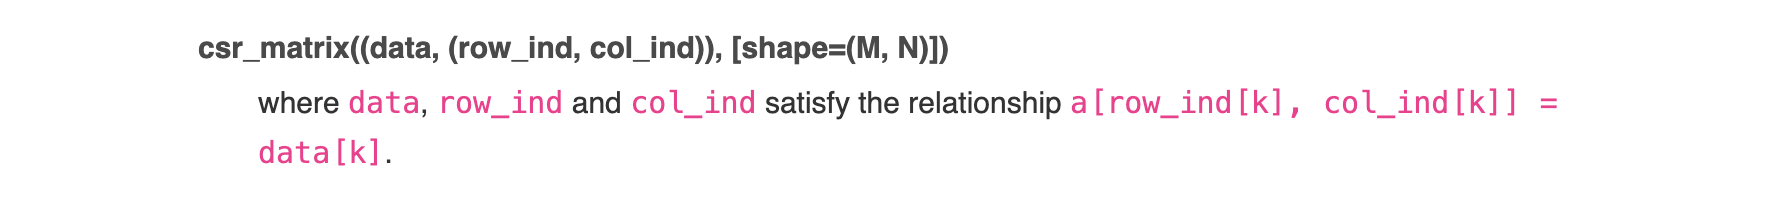
위의 구조로 현재 데이터를 CSR matrix로 만들기
> Duplicate entries are summed together:
```python
>>> row = np.array([0, 1, 2, 0])
>>> col = np.array([0, 1, 1, 0])
>>> data = np.array([1, 2, 4, 8])
>>> csr_matrix((data, (row, col)), shape=(3, 3)).toarray()
array([[9, 0, 0],
       [0, 2, 0],
       [0, 4, 0]])
```

In [32]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data

<358869x291347 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535578 stored elements in Compressed Sparse Row format>

In [39]:
print(num_user)
print(num_artist)

358869
291347


## MF 모델 학습하기

- `implicit` 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
- 이 패키지에 구현된 `als(AlternatingLeastSquares)` 모델을 사용하겠습니다. `Matrix Factorization`에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다

In [33]:
!pip install implicit

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [34]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 `__init__` 파라미터를 살펴보겠습니다.

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지  

1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

In [35]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

---------
---------
---------
---------
##### Transpose 버전을 input으로 넣었을 때 LMS 실습에 오류가 있었다.

In [36]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291347x358869 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535578 stored elements in Compressed Sparse Column format>

In [37]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [42]:
als_model.user_factors.shape

(291347, 100)

In [43]:
als_model.item_factors.shape

(358869, 100)

In [48]:
print(len(user_to_idx))

358869


In [51]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

print('슝=3')

IndexError: index 358868 is out of bounds for axis 0 with size 291347

In [52]:
zimin_vector.shape

(100,)

In [53]:
black_eyed_peas_vector.shape

(100,)

In [54]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.54655933

In [55]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

-0.20071661

In [66]:
als_model.user_factors.shape

(291347, 100)

In [67]:
als_model.item_factors.shape

(358869, 100)

------
------
------
------

In [45]:
als_model.user_factors.shape

(291347, 100)

In [46]:
zimin

358868

In [48]:
als_model.item_factors.shape

(358869, 100)

------
------
------
------

## 비슷한 아티스트 찾기 + 유저에게 추천하기

### 비슷한 아티스트 찾기

`AlternatingLeastSquares` 클래스에 구현되어 있는 `similar_items` 메서드를 통하여 비슷한 아티스트를 찾습니다. 처음으로는 제가 좋아하는 coldplay로 찾아보겠습니다.

In [45]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

(array([    62, 216653, 138722, 298428, 158339, 173400,  59985, 109828,
        115172, 156374,  22900, 356233,  68002,  34900, 204219],
       dtype=int32),
 array([0.9999998 , 0.8573975 , 0.8516895 , 0.8486975 , 0.84697765,
        0.84565943, 0.84027106, 0.83843595, 0.83776116, 0.83481383,
        0.83435154, 0.83339775, 0.8332975 , 0.8328477 , 0.8324996 ],
       dtype=float32))

In [58]:
similar_artist[0].shape

(15,)

In [46]:
idx_to_user = {v:k for k, v in user_to_idx.items()}
[idx_to_user[i[0]] for i in similar_artist]

KeyError: 0.9999998

In [79]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i] for i in similar_artist[0]]

KeyError: 292194

In [78]:
idx_to_artist

{0: 'betty blowtorch',
 1: 'die ärzte',
 2: 'melissa etheridge',
 3: 'elvenking',
 4: 'juliette & the licks',
 5: 'red hot chili peppers',
 6: 'magica',
 7: 'the black dahlia murder',
 8: 'the murmurs',
 9: 'lunachicks',
 10: 'walls of jericho',
 11: 'letzte instanz',
 12: 'goldfrapp',
 13: 'horrorpops',
 14: 'the butchies',
 15: 'jack off jill',
 16: 'babes in toyland',
 17: 'dropkick murphys',
 18: 'all:my:faults',
 19: 'le tigre',
 20: 'schandmaul',
 21: 'edguy',
 22: 'maximum the hormone',
 23: 'all ends',
 24: 'jack johnson',
 25: 'eluveitie',
 26: 'rasputina',
 27: 'london after midnight',
 28: 'the killers',
 29: 'mutyumu',
 30: 'judas priest',
 31: 'rob zombie',
 32: 'the bosshoss',
 33: 'blue öyster cult',
 34: 'sandra nasic',
 35: 'john mayer',
 36: 'sleater-kinney',
 37: 'the who',
 38: 'disciple',
 39: 'tanzwut',
 40: 'guano apes',
 41: 'the rolling stones',
 42: 'little big town',
 43: 'team dresch',
 44: 'betty',
 45: 'l7',
 46: 'bif naked',
 47: 'girlschool',
 48: 'the w

In [73]:
similar_artist

(array([    62, 104894,  70607, 292194, 138722,  15795, 298428, 322380,
        158339, 115172, 346766, 216653, 128407, 204219,  59985],
       dtype=int32),
 array([0.99999994, 0.8440707 , 0.8400548 , 0.83986723, 0.83916914,
        0.8328315 , 0.8320236 , 0.8307075 , 0.82893205, 0.8285601 ,
        0.82757   , 0.82754475, 0.82746255, 0.82427883, 0.82294995],
       dtype=float32))

In [80]:
similar_artist[0]

array([    62, 104894,  70607, 292194, 138722,  15795, 298428, 322380,
       158339, 115172, 346766, 216653, 128407, 204219,  59985],
      dtype=int32)

------------
------------
------------
------------
##### input을 item-user 순서가 아니라 user_item 순서로 넣어서 진행했다.

In [50]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model_2 = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

als_model_2.fit(csr_data)

  0%|          | 0/15 [00:00<?, ?it/s]

In [52]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model_2.user_factors[zimin], als_model_2.item_factors[black_eyed_peas]

print('슝=3')

슝=3


In [53]:
zimin_vector

array([-0.10340158,  0.6059187 , -0.35276857, -0.09484383,  0.09437814,
       -0.01435451, -0.12576237,  1.1014781 ,  0.11844186,  1.047028  ,
       -0.24294432,  0.23739228, -0.42963272,  1.4071763 ,  0.673873  ,
        0.64713204, -1.9122412 ,  0.49764916, -1.264001  ,  0.76327807,
        0.34801924, -0.9097822 , -0.7037951 , -0.9810212 ,  0.06017055,
        0.94446003, -0.28217793,  0.9220494 ,  0.4524752 , -0.41942954,
       -0.02092216, -1.0547411 ,  0.05821073,  0.43536508, -1.0307751 ,
       -0.2900299 ,  0.17660329, -0.28976107,  0.38008186,  0.13055144,
        1.6455609 , -0.16933414,  0.08364923,  0.2452773 , -1.0096179 ,
        0.00269064,  0.29878503,  0.9053697 , -0.8758528 ,  0.7349908 ,
        0.63470393, -0.7609901 ,  0.9353689 , -0.28551498, -0.48351026,
       -0.970738  ,  0.3445297 , -0.51406   ,  0.05678171,  0.5124933 ,
       -0.32928327,  1.5778545 , -0.8576188 , -0.12792727, -0.17877945,
       -0.4923002 , -1.2130809 ,  0.1372932 , -0.1467362 ,  0.25

In [54]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.5252475

In [55]:
queen = artist_to_idx['queen']
queen_vector = als_model_2.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.31278628

In [56]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model_2.similar_items(artist_id, N=15)
similar_artist

(array([  62,  277,    5,   28,  217,  247,  418,  473,  490,  910,  694,
        1018,  268,  782,   75], dtype=int32),
 array([0.9999999 , 0.98754627, 0.97558266, 0.9741579 , 0.9726487 ,
        0.969132  , 0.96727926, 0.9661832 , 0.96357816, 0.9459143 ,
        0.9459063 , 0.9453443 , 0.94481647, 0.9416489 , 0.93558836],
       dtype=float32))

In [59]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i] for i in similar_artist[0]]

['coldplay',
 'muse',
 'red hot chili peppers',
 'the killers',
 'radiohead',
 'the beatles',
 'u2',
 'placebo',
 'oasis',
 'nirvana',
 'foo fighters',
 'the smashing pumpkins',
 'pink floyd',
 'the white stripes',
 'queen']

In [60]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model_2.similar_items(artist_id)
    similar_artist = [idx_to_artist[i] for i in similar_artist[0]]
    return similar_artist

print("슝=3")

슝=3


In [61]:
get_similar_artist('2pac')

['2pac',
 'dr. dre',
 'notorious b.i.g.',
 'the game',
 'snoop dogg',
 'nas',
 'jay-z',
 'ludacris',
 '50 cent',
 'ice cube']

In [62]:
get_similar_artist('lady gaga')

['lady gaga',
 'britney spears',
 'rihanna',
 'katy perry',
 'beyoncé',
 'the pussycat dolls',
 'christina aguilera',
 'justin timberlake',
 'leona lewis',
 'mariah carey']

### 유저에게 아티스트 추천하기

`AlternatingLeastSquares` 클래스에 구현되어 있는 `recommend` 메서드를 통하여 제가 좋아할 만한 아티스트를 추천받습니다. `filter_already_liked_items` 는 유저가 이미 평가한 아이템은 제외하는 Argument입니다.

In [74]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model_2.recommend(user, csr_data, N=20, filter_already_liked_items=True)
artist_recommended

ValueError: user_items must contain 1 row for every user in userids

In [76]:
# and one for recommendations (user-item)
sparse_item_user = csr_matrix((data['play'].astype(float), (data['artist'], data['user_id'])))
sparse_user_item = csr_matrix((data['play'].astype(float), (data['user_id'], data['artist'])))

In [79]:
sparse_item_user.shape

(291347, 358869)

In [80]:
sparse_user_item.shape

(358869, 291347)

In [82]:
csr_data[0].shape

(1, 291347)

In [83]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model_2.recommend(als_model_2.user_factors[user], csr_data[:0], N=20, filter_already_liked_items=True)
artist_recommended

ValueError: user_items must contain 1 row for every user in userids

In [123]:
user

358868

In [138]:
len(als_model_2.user_factors[user])

100

In [139]:
csr_data.shape[0]

358869

In [142]:
csr_data_transpose.shape[0]

291347

In [144]:
sparse_user_item.shape

(358869, 291347)